# Bayesian Decoding

The previous lab developed nonlinear _encoder_ models for predicting neural responses to sensory stimuli.  This lab develops _decoder_ models for inferring movements from neural spike trains.  One way to decode is via Bayesian inference: if we have a strong encoding model and a good prior distribution on movements, we can combine them to infer the posterior distribution of movements given spikes. This allows us to build constraints into the prior; e.g. that movements tend to be smooth. Ultimately, decoding is just another regression problem, and the Bayesian approach offers a convenient way of constructing a conditional distribution of movements given spikes, leveraging prior knowledge about how movements unfold.

We'll use a dataset from [Prof. Krishna Shenoy](https://engineering.stanford.edu/magazine/krishna-shenoy-engineer-who-reimagined-how-brain-makes-body-move-dies-54), a leader in the field of motor neuroscience and brain-computer interfaces who sadly passed away a few years ago. The data consists of a 96-channel Utah array recording from motor cortex of a non-human primate performing a center-out reaching task. The data and a related model are described in (Gilja\*, Nuyujukian\*, et al, 2012).

**References**

Gilja, Vikash, Paul Nuyujukian, Cindy A. Chestek, John P. Cunningham, Byron M. Yu, Joline M. Fan, Mark M. Churchland, et al. 2012. “A High-Performance Neural Prosthesis Enabled by Control Algorithm Design.” _Nature Neuroscience_ 15 (12): 1752–57.


## Setup

In [ ]:
%%capture
try:
    import jaxtyping
except:
    !pip install jaxtyping

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.distributions import MultivariateNormal

from dataclasses import dataclass
from jaxtyping import Float, Int
from torch import Tensor


In [ ]:
#@title Helper functions

# Set some plotting defaults
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "greyish",
                            "orange",
                            "amber",
                            "clay",
                            "pink"])

@dataclass
class Trial:
    """
    A simple dataclass to hold the data for a single trial.

    Attributes
    ----------
    spikes: Float[Tensor, "num_timebins num_neurons"]
        The neural activity of the trial.
    position: Float[Tensor, "num_timebins 2"]
        The position of the cursor in 2D space.
    velocity: Float[Tensor, "num_timebins 2"]
        The velocity of the cursor in 2D space.
    condition: int
        The condition (reach direciton) of the trial.
    """
    spikes: Float[Tensor, "num_timebins num_neurons"]
    position: Float[Tensor, "num_timebins 2"]
    velocity: Float[Tensor, "num_timebins 2"]
    condition: int


class ReachDataset(Dataset):
    """A simple dataset object.

    Attributes
    ----------
    all_spikes: Float[Tensor, "num_trials num_timebins num_neurons"]
        The neural activity from all the trials.
    all_positions: Float[Tensor, "num_trials num_timebins 2"]
        The position of the cursor in 2D space for all trials.
    all_velocities: Float[Tensor, "num_trials num_timebins 2"]
        The velocity of the cursor in 2D space for all trials.
    all_conditions: Int[Tensor, "num_trials"]
        The condition (reach direction) of all trials.
    """
    all_spikes: Float[Tensor, "num_trials num_timebins num_neurons"]
    all_positions: Float[Tensor, "num_trials num_timebins 2"]
    all_velocities: Float[Tensor, "num_trials num_timebins 2"]
    all_conditions: Int[Tensor, "num_trials"]

    def __init__(self,
                 spikes: Float[Tensor, "num_trials num_timebins num_neurons"],
                 position: Float[Tensor, "num_trials num_timebins 2"],
                 velocity: Float[Tensor, "num_trials num_timebins 2"],
                 condition: Int[Tensor, "num_trials"]) -> None:
        self.all_spikes = spikes
        self.all_positions = position
        self.all_velocities = velocity
        self.all_conditions = condition
        assert len(self.all_spikes) == len(self.all_positions)
        assert len(self.all_spikes) == len(self.all_velocities)
        assert len(self.all_spikes) == len(self.all_conditions)

    def __len__(self):
        return self.all_spikes.shape[0]

    def __getitem__(self, idx: int) -> Trial:
        """
        Get a single trial from the dataset.

        Parameters
        ----------
        idx: int
            The index of the trial to get.

        Returns
        -------
        Trial
            A Trial object containing the spikes, position, velocity, and condition
            of the trial.
        """
        return Trial(spikes=self.all_spikes[idx],
                     position=self.all_positions[idx],
                     velocity=self.all_velocities[idx],
                     condition=self.all_conditions[idx])

def plot_trial(dataset: ReachDataset,
               idx: int,
               bin_size: int=25):
    """
    Plot the spikes, position, and velocity of a single trial.

    Parameters
    ----------
    dataset: ReachDataset
        The dataset to plot.
    idx: int
        The index of the trial to plot.
    bin_size: int
        The size of the time bins in ms.
    """
    trial = dataset[idx]
    fig, axs = plt.subplots(3, 1, sharex=True)
    axs[0].imshow(trial.spikes.T,
                interpolation="none",
                aspect="auto",
                cmap="Greys")
    axs[0].set_ylabel("channel")
    axs[0].set_title("spike counts")

    axs[1].plot(trial.position[:, 0], label='x coord.')
    axs[1].plot(trial.position[:, 1], label='y coord.')
    axs[1].set_ylabel("[mm]")
    axs[1].legend()
    axs[1].set_title("cursor position")

    axs[2].plot(trial.velocity[:, 0], label='x coord.')
    axs[2].plot(trial.velocity[:, 1], label='y coord.')
    axs[2].set_xlabel("time bin [{}ms]".format(bin_size))
    axs[2].set_ylabel("[mm / bin]")
    axs[2].legend()
    axs[2].set_title("cursor velocity")

    fig.suptitle("Trial {} (reach direction {})".format(idx, trial.condition))
    plt.tight_layout()


def plot_reach_trajectories(dataset: ReachDataset) -> None:
    """
    Plot the reach trajectories of the cursor for a set of trials.

    Parameters
    ----------
    dataset: ReachDataset
        The dataset to plot.
    """
    for trial in dataset:
        plt.plot(trial.position[:, 0],
                 trial.position[:, 1],
                 color=palette[trial.condition])

    plt.xlabel("cursor x position [mm]")
    plt.ylabel("cursor y position [mm]")
    plt.gca().set_aspect("equal")
    plt.tight_layout()


def plot_decoder(dataset: ReachDataset,
                 decoder: nn.Module) -> None:
    """
    Plot the true and decoded trajectories of the cursor for a set of trials.

    Parameters
    ----------
    dataset: ReachDataset
        The dataset to plot.
    decoder: SimpleDecoder
        The decoder to use for plotting.

    """
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
    for trial in dataset:
        # decode velocity and integrate to get position
        dec_velocity = decoder(trial.spikes)[0]
        dec_position = trial.position[0] + torch.cumsum(dec_velocity, axis=0)

        color = palette[trial.condition]
        axs[0].plot(trial.position[:, 0], trial.position[:, 1], color=color)
        axs[1].plot(dec_position[:, 0], dec_position[:, 1], color=color)

    axs[0].set_title("test movements")
    axs[0].set_xlabel("cursor x position")
    axs[0].set_ylabel("cursor y position")
    axs[1].set_xlabel("cursor x position")
    axs[1].set_title("decoded test movements")
    plt.tight_layout()

def plot_predictions(dataset: ReachDataset,
                     idx: int,
                     decoder: nn.Module) -> None:
    """
    Plot the true and decoded trajectories of the cursor for a set of trials.

    Parameters
    ----------
    dataset: ReachDataset
        The dataset to plot.
    idx: int
        The index of the trial to plot.
    decoder: SimpleDecoder
        The decoder to use for plotting.

    """
    trial = dataset[idx]
    decoder_mean, decoder_covar = decoder(trial.spikes)
    if decoder_covar.ndim == 2:
        decoder_covar = decoder_covar.unsqueeze(0).repeat(len(trial.velocity), 1, 1)

    fig, axs = plt.subplots(2, 1, sharex=True)
    axs[0].imshow(trial.spikes.T,
                interpolation="none",
                aspect="auto",
                cmap="Greys")
    axs[0].set_ylabel("channel")
    axs[0].set_title("spike counts")

    h = axs[1].plot(trial.velocity[:, 0], ls='-', lw=2, label='true x vel.')[0]
    axs[1].plot(decoder_mean[:, 0], ls=':', color=h.get_color(), label='pred. x vel.')
    axs[1].fill_between(range(len(trial.velocity)),
                        decoder_mean[:, 0] - 2*torch.sqrt(decoder_covar[:, 0, 0]),
                        decoder_mean[:, 0] + 2*torch.sqrt(decoder_covar[:, 0, 0]),
                        alpha=0.2, color=h.get_color())

    h = axs[1].plot(trial.velocity[:, 1], ls='-', lw=2, label='true y vel.')[0]
    axs[1].plot(decoder_mean[:, 1], ls=':', color=h.get_color(), label='pred. y vel.')
    axs[1].fill_between(range(len(trial.velocity)),
                        decoder_mean[:, 1] - 2*torch.sqrt(decoder_covar[:, 1, 1]),
                        decoder_mean[:, 1] + 2*torch.sqrt(decoder_covar[:, 1, 1]),
                        alpha=0.2, color=h.get_color())

    axs[1].set_xlabel("time bin")
    axs[1].set_ylabel("[mm / bin]")
    axs[1].legend(ncol=2, loc='upper right', fontsize='small')
    axs[1].set_title("cursor velocity")

    fig.suptitle("Trial {} (reach direction {})".format(idx, trial.condition))
    plt.tight_layout()



### Load the data

We have preprocessed the data into training and test dictionaries. Each dictionary contains the following keys:
- `spikes` a ($R \times T \times 96$) array of spike counts for each of the 96 channels where $R$ is the number of trials and $T$ is the number of 25ms time bins per trial
- `position` a ($R \times T \times 2$) array of cursor positions
- `velocity` a ($R \times T \times 2$) array of estimated cursor velocities
- `condition` a length $R$ tensor containing integers $0,\ldots,8$ specifying the reaching condition (i.e. starting point and target)

In [ ]:
!wget -nc https://github.com/slinderman/ml4nd/raw/refs/heads/main/data/05_decoding/lab5_data.pt

### Package the data into datasets

Package the data dictionaries into `ReachDataset` objects defined above for easier access and iteration.

In [ ]:
# Load the data and create datasets
_train_data, _test_data = torch.load('lab5_data.pt')
train_dataset = ReachDataset(**_train_data)
test_dataset = ReachDataset(**_test_data)

# Delete the dictionaries so that we don't accidentally reference them
del _train_data, _test_data

In [ ]:
# Set some global constants
NUM_TRIALS = len(train_dataset)
NUM_TIMEBINS = train_dataset.all_spikes.shape[1]
NUM_NEURONS = train_dataset.all_spikes.shape[2]

### Plot the spike counts and position/velocity times for a single trial

Let's look at one trial. It consists of a time series of spike counts from each channel of the Utah array, as well as a position time series. We also plot the velocity, which is just a first-order estimate of the derivative of the position.

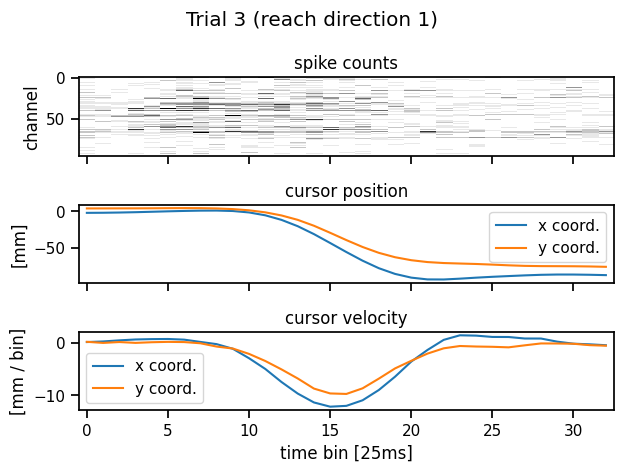

In [ ]:
plot_trial(train_dataset, 3)

### Plot the cursor positions across all trials

Plot the reach directions color-coded by the condition type. Most conditions start at the center and move outward to a target. One condition type (gray) starts at the perimeter and moves to the center.

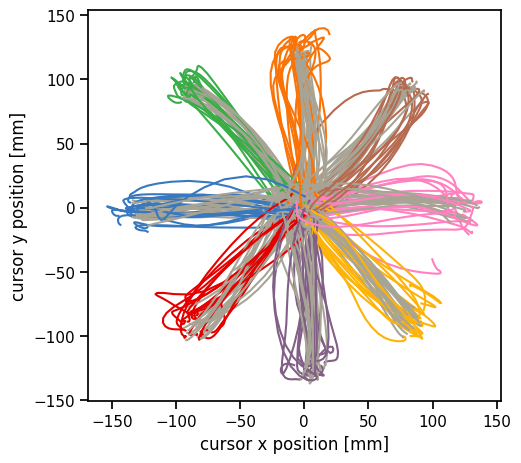

In [ ]:
plot_reach_trajectories(train_dataset)

## Part 1: Implement a simple Bayesian decoder

Our first model is a simple Bayesian decoder to infer the velocity given the spike counts. We will make two main assumptions:
1. We assume neural activity at time $t$ depends on the velocity at time $t$ alone.
2. We assume a linear Gaussian model to relate velocity to spike counts.

Neither assumption is warranted in practice, and we will improve our model in subsequent sections.

Let $\mathbf{x}_{i,t} \in \mathbb{R}^2$ denote the **cursor velocity** at time $t$ on trial $i$. Likewise, let $\mathbf{y}_{i,t} \in \mathbb{R}^{96}$ denote the spike count measured on the 96-channel array at time $t$ on trial $i$. Our model is,

$$
\begin{aligned}
\mathbf{x}_{i,t} &\sim \mathrm{N}(\mathbf{m}, \mathbf{Q}) \\
\mathbf{y}_{i,t} \mid \mathbf{x}_{i,t} &\sim \mathrm{N}(\mathbf{C} \mathbf{x}_{i,t} + \mathbf{d}, \mathbf{R}).
\end{aligned}
$$

with parameters,
- $\mathbf{m} \in \mathbb{R}^{2}$: the prior mean of the velocity
- $\mathbf{Q} \in \mathbb{R}^{2 \times 2}$: the prior covariance of the velocity
- $\mathbf{C} \in \mathbb{R}^{96 \times 2}$: the _emission_ matrix
- $\mathbf{d} \in \mathbb{R}^{96}$: the _emission_ bias
- $\mathbf{R} \in \mathbb{R}^{96 \times 96}$: the _emission_ covariance
Note that $\mathbf{Q}$ and $\mathbf{R}$ are positive definite matrices.

As we derived in the notes, the posterior distribution of the velocity given the spike counts is,

$$
\begin{aligned}
p(\mathbf{x}_{i,t} \mid \mathbf{y}_{i,t}) &= \mathrm{N}(\boldsymbol{\mu}_{i,t}, \boldsymbol{\Sigma}_{i,t}) \\
\boldsymbol{\mu}_{i,t} &= \mathbf{J}_{i,t}^{-1} \mathbf{h}_{i,t},  \\
\boldsymbol{\Sigma}_{i,t} &= \mathbf{J}_{i,t}^{-1},  \\
\mathbf{J}_{i,t} &= \mathbf{Q}^{-1} + \mathbf{C}^\top \mathbf{R}^{-1} \mathbf{C}, \\
\mathbf{h}_{i,t} &= \mathbf{Q}^{-1} \mathbf{m} + \mathbf{C}^\top \mathbf{R}^{-1}(\mathbf{y}_{i,t} - \mathbf{d}),
\end{aligned}
$$

where $(\boldsymbol{\mu}_{i,t}, \boldsymbol{\Sigma}_{i,t})$ are the posterior mean and covariance, respectively, and $(\mathbf{J}_{i,t}, \mathbf{h}_{i,t})$ are the _natural_ (aka _information-form_) parameters.


In Part 1, you'll estimate the parameters of this model, $\{\mathbf{Q}, \mathbf{C}, \mathbf{d}, \mathbf{R}\}$ and implement the simple decoder as a PyTorch module.

### Problem 1a: Estimate the prior mean and covariance

Compute the empirical mean and covariance of the velocities,

$$
\begin{aligned}
\hat{\mathbf{m}} &= \frac{1}{RT} \sum_{i=1}^R \sum_{t=1}^{T} \mathbf{x}_{i,t} \\
\hat{\mathbf{Q}} &= \frac{1}{RT} \left(\sum_{i=1}^R \sum_{t=1}^{T} (\mathbf{x}_{i,t} - \hat{\mathbf{m}}) (\mathbf{x}_{i,t} - \hat{\mathbf{m}})^\top \right).
\end{aligned}
$$


In [ ]:
def estimate_basic_prior_prms(
        dataset: ReachDataset
        ) -> tuple[Float[Tensor, "2"], Float[Tensor, "2 2"]]:
    """
    Compute the covariance of the velocity over all
    trials and time steps.

    Parameters
    ----------
    dataset: ReachDataset
        The dataset to compute the covariance from.

    Returns
    -------
    m_hat: Float[Tensor, "2"]
        The mean of the velocity over all trials and time steps.
    Q_hat: Float[Tensor, "2 2"]
        The covariance of the velocity over all trials and time steps.

    """
    ###
    # YOUR CODE BELOW
    m_hat = ...
    Q_hat = ...
    ###

    return m_hat, Q_hat

### Problem 1b: Estimate the encoding model parameters

Estimate $\mathbf{C} \in \mathbb{R}^{96 \times 2}$, $\mathbf{d} \in \mathbb{R}^{96}$, and $\mathbf{R} \in \mathbb{R}^{96 \times 96}$ by fitting a linear regression to the training velocity and spikes.

Let $\mathbf{X} \in \mathbb{R}^{RT \times 3}$ denote the matrix of concatenated velocities across all trials with an additional column of ones for the intercept. Let $\mathbf{Y} \in \mathbb{R}^{RT \times 96}$ denote a matrix of spike counts concatenated across all trials.

The ordinary least squares estimate of the regression weights is,

$$
\hat{\mathbf{W}} = \mathbf{Y}^\top \mathbf{X} (\mathbf{X}^\top \mathbf{X})^{-1}
$$

where $\hat{\mathbf{W}} = [\hat{\mathbf{C}}, \hat{\mathbf{d}}] \in \mathbb{R}^{96 \times 3}$ are the desired parameters.

For the covariance matrix, use the empirical covariance of the residuals, $\hat{\mathbf{R}} = \mathrm{Cov}(\boldsymbol{\delta}_{i,t})$, where $\boldsymbol{\delta}_{i,t} = \mathbf{y}_{i,t} - \hat{\mathbf{C}} \mathbf{x}_{i,t} - \hat{\mathbf{d}}$.



In [ ]:
def estimate_emission_prms(
        dataset: ReachDataset
        ) -> tuple[Float[Tensor, "num_neurons 2"],
                   Float[Tensor, "num_neurons"],
                   Float[Tensor, "num_neurons num_neurons"]]:
    """
    Compute the parameters of the simple encoding model.

    Parameters
    ----------
    dataset: ReachDataset
        The dataset to compute the parameters from.

    Returns
    -------
    C_hat: Float[Tensor, "num_neurons 2"]
        The encoding emission matrix.
    d_hat: Float[Tensor, "num_neurons"]
        The encoding emission bias.
    R_hat: Float[Tensor, "num_neurons num_neurons"]
        The covariance of encoding model.
    """

    ###
    # YOUR CODE HERE
    C_hat = ...
    d_hat = ...
    R_hat = ...
    ###

    return C_hat, d_hat, R_hat

### Problem 1c: Implement the simple decoder model

Implement the simple decoder as a PyTorch `Module`. We won't be fitting any parameters (you just estimated them above!).

Specifically, complete the `forward` function to compute `mu`, and `Sigma`, and the `log_prob` function to compute the log probability of a trial's velocity given the corresponding spikes.

In [ ]:
class SimpleDecoder(nn.Module):
    """
    A simple decoder that estimates the posterior mean and covariance of the
    velocity given the spikes, assuming a Gaussian prior and a linear Gaussian
    encoder model.

    Attributes
    ----------
    m: Float[Tensor, "2"]
        The mean of the prior distribution.
    Q: Float[Tensor, "2 2"]
        The covariance of the prior distribution.
    C: Float[Tensor, "num_neurons 2"]
        The encoding emission matrix.
    d: Float[Tensor, "num_neurons"]
        The encoding emission bias.
    R: Float[Tensor, "num_neurons num_neurons"]
        The covariance of the encoding model.
    """
    m: Float[Tensor, "2"]
    Q: Float[Tensor, "2 2"]
    C: Float[Tensor, "num_neurons 2"]
    d: Float[Tensor, "num_neurons"]
    R: Float[Tensor, "num_neurons num_neurons"]

    def __init__(self,
                 m: Float[Tensor, "2"],
                 Q: Float[Tensor, "2 2"],
                 C: Float[Tensor, "num_neurons 2"],
                 d: Float[Tensor, "num_neurons"],
                 R: Float[Tensor, "num_neurons num_neurons"]
                 ) -> None:
        super(SimpleDecoder, self).__init__()

        # Store the parameters
        self.m = m
        self.Q = Q
        self.C = C
        self.d = d
        self.R = R

    def forward(self,
                spikes: Float[Tensor, "num_timebins num_neurons"]
                ) -> tuple[Float[Tensor, "num_timebins 2"],
                           Float[Tensor, "2 2"]]:
        """
        Compute the posterior mean and covariance of the velocity given the spikes
        for a single trial.

        Parameters
        ----------
        spikes: Float[Tensor, "num_timebins num_neurons"]
            The neural activity of the trial.

        Returns
        -------
        mu: Float[Tensor, "num_timebins 2"]
            The posterior mean of the velocity.
        Sigma: Float[Tensor, "2 2"]
            The posterior covariance of the velocity (it is the same for all time bins).
        """
        # Get the model parameters so we don't always have to reference self
        m, Q, C, d, R = self.m, self.Q, self.C, self.d, self.R

        ###
        # YOUR CODE BELOW
        #
        mu = ...
        Sigma = ...
        ##

        # Return the mean and covariance
        return mu, Sigma

    def log_prob(self,
                 spikes: Float[Tensor, "num_timebins num_neurons"],
                 velocity: Float[Tensor, "num_timebins 2"]
                 ) -> float:
        """
        Compute the log probability of the velocity given the spikes
        for a single trial, using this simple model.

        Hint: use the `forward` method to compute the posterior mean and covariance
        and plug that into the log probability written above.

        Parameters
        ----------
        spikes: Float[Tensor, "num_timebins num_neurons"]
            The neural activity of the trial.
        velocity: Float[Tensor, "num_timebins 2"]
            The true velocity of the cursor in 2D space.

        Returns
        -------
        log_prob: float
            The log probability of the velocity given the spikes,
                \sum_t \log p(x_{i,t} | y_{i,t}),
            as described above.

        """
        ##
        # YOUR CODE BELOW
        lp = ...
        ##

        return lp

### Instantiate the model

That's it! No fitting required. You already estimated the parametes in Problems 1a and 1b.

In [ ]:
m_hat, Q_hat = estimate_basic_prior_prms(train_dataset)
C_hat, d_hat, R_hat = estimate_emission_prms(train_dataset)
simple_decoder = SimpleDecoder(m_hat, Q_hat, C_hat, d_hat, R_hat)

### Plot the decoded positions
Now we'll decode the velocities from the test set and integrate them to get positions that we can compare to the true cursor trajectories.

In [ ]:
# Plot the decoded trajectories
plot_decoder(test_dataset, simple_decoder)

In [ ]:
# Plot the decoded trajectory for a single trial
plot_predictions(test_dataset, 3, simple_decoder)

## Part 2: Bayesian decoding with a correlated prior

The simple model failed to account for the clear temporal correlations in the velocities: cursors tend to move in smooth trajectories, but the simple model treated the velocity as independent across time bins. In this section, we'll address this shortcoming by using a multivariate Gaussian prior on the sequence of velocities across a trial.

Let $\mathbf{X}_i \in \mathbb{R}^{T \times 2}$ denote the matrix of velocities across trial $i$. The rows of this matrix are the instantaneous velocities, $\mathbf{x}_{i,t} \in \mathbb{R}^2$.

In our next model, we will place a multivariate normal prior on the _vectorized_ matrix, $\mathrm{vec}(\mathbf{X}_i) = (\mathbf{x}_{i,1}, \ldots, \mathbf{x}_{i,T}) \in \mathbb{R}^{2T}$. Specifically, assume,

$$
\begin{align}
\mathrm{vec}(\mathbf{X}_{i}) &\sim \mathrm{N}(\mathbf{m}, \mathbf{Q}) \\
\mathbf{y}_{i,t} \mid \mathbf{x}_{i,t} &\stackrel{\text{ind}}{\sim} \mathrm{N}(\mathbf{C} \mathbf{x}_{i,t} + \mathbf{d}, \mathbf{R})
 & \text{for }  t&=1,\ldots, T.
\end{align}
$$

where, with a slight abuse of notation, we have redefined the prior parameters from Part 1 to be,
- $\mathbf{m} \in \mathbb{R}^{2T}$ is the mean of the vectorized matrix of velocities,
- $\mathbf{Q} \in \mathbb{R}^{2T \times 2T}$ is the covariance of the vectorized matrix of velocities.

This is still a linear Gaussian model, and the posterior distribution over $\mathbf{X}_i$ will again be Gaussian. However, under this model, the posterior will capture correlations across time.


### Problem 2a [Math]: Derive the posterior distribution

Since the model is linear and Gaussian, the posterior distribution of the velocities is also a multivariate Gaussian,

$$
\begin{align}
p(\mathrm{vec}(\mathbf{X}_i) \mid \mathbf{Y}_i)
&= \mathrm{N}\left( \mathrm{vec}(\mathbf{X}_i) \mid
    \boldsymbol{\mu}_i, \mathbf{\Sigma}_i
    \right).
\end{align}
$$

but here the posterior mean is $\boldsymbol{\mu}_i \in \mathbb{R}^{2T}$ and the posterior covariance matrix is $\boldsymbol{\Sigma}_i \in \mathbb{R}^{2T \times 2T}$.

Derive the posterior mean and covariance in terms of the model parameters and the spikes.

---

_Your answer here_

### Problem 2b: Estimate the prior parameters

Estimate the prior covariance mean, $\hat{\mathbf{m}} \in \mathbb{R}^{2T}$, and covariance matrix, $\hat{\mathbf{Q}} \in \mathbb{R}^{2T \times 2T}$, using the empirical mean and covariance of the flattened velocities, $\mathrm{vec}(\mathbf{X}_i)$, across trials.

In [ ]:
def estimate_correlated_prior_prms(
        dataset: ReachDataset
        ) -> tuple[Float[Tensor, "2*num_timebins"],
                   Float[Tensor, "2*num_timebins 2*num_timebins"]]:
    """
    Compute the covariance of the velocity over all
    trials and time steps.

    Parameters
    ----------
    dataset: ReachDataset
        The dataset to compute the covariance from.

    Returns
    -------
    m_hat: Float[Tensor, "2*num_timebins"]
        The mean of the velocity sequence over all trials
    Q_hat: Float[Tensor, "2*num_timebins 2*num_timebins"]
        The covariance of the velocity sequence over all trials

    """
    ###
    # YOUR CODE BELOW
    m_hat = ...
    Q_hat = ...
    ###

    return m_hat, Q_hat

m_hat, Q_hat = estimate_correlated_prior_prms(train_dataset)
assert m_hat.shape == (2 * train_dataset.all_velocities.shape[1],)
assert Q_hat.shape == (2 * train_dataset.all_velocities.shape[1],
                        2 * train_dataset.all_velocities.shape[1])

### Problem 2c: Plot the prior covariance and correlation matrices

Plot the estimated prior covariance matrix $\hat{\mathbf{Q}}$ and the corresponding correlation matrix, which you obtain by dividing the rows and columns by the standard deviations.

Make sure your plots have titles, axis labels, colorbars, etc.

In [ ]:
##
# YOUR CODE HERE
##


### Problem 2d: Implement the correlated decoder

Implement the correlated decoder as a PyTorch module, using your derivations from Problem 2a.

Your `forward` function should return $\boldsymbol{\mu}$ as a `T x 2` tensor and $\boldsymbol{\Sigma}$ as a `2T x 2T` tensor.

**Note**: Computing $\boldsymbol{\Sigma}$ requires a matrix inversion that takes $O(T^3)$ operations since it's a $2T \times 2T$ matrix.  We can cut down on this cost if we make simplifying assumptions on the prior covariance of $\mathbf{X}_i$. We'll talk more about later in the course. For now, just pay the cubic price since these matrices aren't that big anyway.

In [ ]:
class CorrelatedDecoder(nn.Module):
    """
    The correalted decoder that estimates the posterior mean and covariance of the
    velocity given the spikes, assuming a correlated Gaussian prior over the sequence
    of velocities. We still use a linear Gaussian encoder for each time bin, as above.

    Attributes
    ----------
    m: Float[Tensor, "2*num_timebins"]
        The mean of the prior distribution.
    Q: Float[Tensor, "2*num_timebins 2*num_timebins"]
        The covariance of the prior distribution.
    C: Float[Tensor, "num_neurons 2"]
        The encoding emission matrix.
    d: Float[Tensor, "num_neurons"]
        The encoding emission bias.
    R: Float[Tensor, "num_neurons num_neurons"]
        The covariance of the encoding model.
    """
    m: Float[Tensor, "2*num_timebins"]
    Q: Float[Tensor, "2*num_timebins 2*num_timebins"]
    C: Float[Tensor, "num_neurons 2"]
    d: Float[Tensor, "num_neurons"]
    R: Float[Tensor, "num_neurons num_neurons"]

    def __init__(self,
                 m: Float[Tensor, "2*num_timebins"],
                 Q: Float[Tensor, "2*num_timebins 2*num_timebins"],
                 C: Float[Tensor, "num_neurons 2"],
                 d: Float[Tensor, "num_neurons"],
                 R: Float[Tensor, "num_neurons num_neurons"]
                 ) -> None:
        super(CorrelatedDecoder, self).__init__()

        # Store the parameters
        self.m = m
        self.Q = Q
        self.C = C
        self.d = d
        self.R = R

    def forward(self,
                spikes: Float[Tensor, "num_timebins num_neurons"]
                ) -> tuple[Float[Tensor, "num_timebins 2"],
                           Float[Tensor, "2*num_timebins 2*num_timebins"]]:
        """
        Compute the posterior mean and covariance of the velocity given the spikes
        for a single trial.

        Parameters
        ----------
        spikes: Float[Tensor, "num_timebins num_neurons"]
            The neural activity of the trial.

        Returns
        -------
        mu: Float[Tensor, "num_timebins 2"]
            The posterior mean of the velocity.
        Sigma: Float[Tensor, "2*num_timebins 2*num_timebins"]
            The posterior covariance of the velocity
        """
        # Get the model parameters so we don't always have to reference self
        m, Q, C, d, R = self.m, self.Q, self.C, self.d, self.R

        ###
        # YOUR CODE BELOW
        #
        mu = ...
        Sigma = ...
        ##

        # Return the mean and covariance
        return mu, Sigma

    def log_prob(self,
                 spikes: Float[Tensor, "num_timebins num_neurons"],
                 velocity: Float[Tensor, "num_timebins 2"]
                 ) -> float:
        """
        Compute the log probability of the velocity given the spikes
        for a single trial, using this simple model.

        Hint: use the `forward` method to compute the posterior mean and covariance
        and plug that into the log probability written above.

        Parameters
        ----------
        spikes: Float[Tensor, "num_timebins num_neurons"]
            The neural activity of the trial.
        velocity: Float[Tensor, "num_timebins 2"]
            The true velocity of the cursor in 2D space.

        Returns
        -------
        log_prob: float
            The log probability of the velocity given the spikes,
                \sum_t \log p(x_{i,t} | y_{i,t}),
            as described above.

        """
        ##
        # YOUR CODE BELOW
        lp = ...
        ##

        return lp

### Instantiate the model

In [ ]:
# Estimate the parameters and create the decoder
m_hat, Q_hat = estimate_correlated_prior_prms(train_dataset)
C_hat, d_hat, R_hat = estimate_emission_prms(train_dataset)
correlated_decoder = CorrelatedDecoder(m_hat, Q_hat, C_hat, d_hat, R_hat)

### Plot the decoded positions
Once again, that's it! No more fitting required. You already estimated the parameters in Problems 1a and 1b. Now we'll decode the velocities from the test set and integrate them to get positions that we can compare to the true cursor trajectories.

In [ ]:
# Plot the decoded trajectories
plot_decoder(test_dataset, correlated_decoder)

In [ ]:
# Plot the decoded velocity time series for one trial
plot_predictions(test_dataset, 3, correlated_decoder)

## Part 3: Model Comparison

Compare your models in terms of two quantities:
1. The mean squared error of the decoded velocities (using the posterior mean as your prediction).
2. The log probabilities of the velocity traces under your model.

In both cases, compare your model to the static decoder provided below, which always outputs the same distribution regardless of the spikes.

In [ ]:
class StaticDecoder(nn.Module):
    """
    A static decoder that always outputs the mean and covariance
    of the prior distribution, regardless of the spikes.
    """
    m: Float[Tensor, "2"]
    Q: Float[Tensor, "2 2"]

    def __init__(self, m, Q):
        self.m = m
        self.Q = Q
        super().__init__()

    def forward(self, spikes):
        T = spikes.shape[0]
        return self.m.repeat(T, 1), self.Q

    def log_prob(self, spikes, velocity):
        return MultivariateNormal(self.m, self.Q).log_prob(velocity).sum()

baseline_decoder = StaticDecoder(
    train_dataset.all_velocities.reshape(-1, 2).mean(axis=0),
    train_dataset.all_velocities.reshape(-1, 2).T.cov(correction=0)
    )



### Problem 3a: Compare the mean squared errors of your models

Make a bar plot of the mean squared error of your models' predictions on test data vs the static baseline provided above. You should have three bars:
1. The static decoder
2. The simple decoder from Part 1
3. The correlated decoder from Part 2

In [ ]:
##
# YOUR CODE HERE
##

### Problem 3b: Compare the log probability of your models

Make a bar plot of the change in log probability under your models over the static decoder baseline, averaged over the test data. You should have two bars.
1. The average log probability under simple decoder minus the average log probability under the static baseline
2. The average log probability under correlated decoder minus the average log probability under the static baseline


In [ ]:
##
# YOUR CODE HERE
##

## Part 4: Discussion



### Problem 4a
Why do you think we decoded velocity instead of position? What are the limitations of decoding velocity and then integrating it to obtain position estimates?

---

_Your answer here_

### Problem 4b

Decoding performance could be limited by either the amount of information about movement contained in the neural activity, or by the particular form of decoder that we employed. What do you think the limiting factor is in this lab?
 Why?

---

_Your answer here_

### Problem 4c

Our encoder only used the velocity at time $t$ to predict the spike counts at time $t$. Write the log likelihood (but do not implement or fit) a model that uses a window of velocities to predict the spike counts. Describe (but do not fully derive) how you would compute the posterior distribution over velocities given spikes under this model. What challenges would your model present?

---

_Your answer here_

### Problem 4d
Suppose we wanted to use the decoder to control a prosthetic limb and we needed it to work for months or years at a time. Would you expect the same decoder parameters to work throughout that time course, and if not, how might you adapt the decoder over time to maintain or potentially even improve performance?

---

_Your answer here_

## Author contributions

Write a short paragraph describing how each team member contributed to this assignment.

_Your answer here_

## Submission Instructions


Download your notebook in .ipynb format and use the following command to convert it to PDF
```
jupyter nbconvert --to pdf lab5_name.ipynb
```
If you're using Anaconda for package management, you can install `nbconvert` with
```
conda install -c anaconda nbconvert
```
Upload your .pdf file to Gradescope.

**Only one submission per team!**